In [1]:
cd ..

/home/pierreo/semisupervised


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats
from module.utils import bounded_bivariate_normal_integral

/home/pierreo/miniconda3/envs/semisupervised/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Test Wolfe

In [3]:
def wolfe(mean, covar, c1= 0.0001, c2 = 0.9, t = 1):
    A_transform = torch.tensor([[1, c1*t, -1, 0], [0, -c2, 0, 1]])
    
    mean_wolfe = A_transform @ mean
    covar_wolfe = A_transform @ covar @ A_transform.T
    # Very small variances can cause numerical problems. Safeguard against
    # this with a deterministic evaluation of the Wolfe conditions.
    
    # Compute correlation factor and integration bounds for adjusted p_Wolfe
    # and return the result of the bivariate normal integral.
    rho = (covar_wolfe[0,1]/torch.sqrt(covar_wolfe[0,0]*covar_wolfe[1,1])).detach().cpu()
    al = -(mean_wolfe[0]/torch.sqrt(covar_wolfe[0,0])).detach().cpu()
    bl = -(mean_wolfe[1]/torch.sqrt(covar_wolfe[1,1])).detach().cpu()
    
    return bounded_bivariate_normal_integral(rho, al, torch.inf, bl, torch.inf)

In [4]:
covar_joint = torch.tensor([[0.1, 0.05, 0., 0.],
                            [0.05, 0.1, 0., 0.],
                            [0., 0., 1., 0.1],
                            [0., 0., 0.1, 1.]])
mean_joint = torch.tensor([1., -1., 2., 1.])

wolfe(mean_joint, covar_joint)

tensor(0.1616)

In [5]:
covar_joint = torch.tensor([[0.1, 0.05, 0., 0.],
                            [0.05, 0.1, 0., 0.],
                            [0., 0., 0.1, 0.01],
                            [0., 0., 0.01, 0.1]])
mean_joint = torch.tensor([1., -1., 2., 1.])

wolfe(mean_joint, covar_joint)

tensor(0.0127)

## Test joint distribution

In [3]:
import numpy as np
from module.quadrature import Quadrature, QuadratureExplorationBis
from botorch.models import SingleTaskGP
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from module.utils import nearestPD
from botorch.test_functions.synthetic import Ackley, Rosenbrock, Rastrigin


def plot_GP_fit(model, distribution, train_X, targets, obj, normalize=False, lb=-10., up=10., mean_Y=None, std_Y=None):
    """ Plot the figures corresponding to the Gaussian process fit
    """
    model.eval()
    model.likelihood.eval()
    test_x = torch.linspace(lb, up, 200, device=train_X.device, dtype=train_X.dtype)
    with torch.no_grad():
        # Make predictions
        predictions = model.likelihood(model(test_x))
        lower, upper = predictions.confidence_region()
    
    if normalize:
        predictions = predictions*float(std_Y) + float(mean_Y)
        lower, upper = lower*float(std_Y) + float(mean_Y), upper*float(std_Y) + float(mean_Y)
        targets = targets*float(std_Y) + float(mean_Y)
    value_ = (obj(test_x.unsqueeze(-1))).flatten()

    plt.scatter(train_X.cpu().numpy(), targets.cpu().numpy(), color='black', label='Training data')
    plt.plot(test_x.cpu().numpy(), predictions.mean.cpu().numpy(), color='blue', label='Predictive mean')
    plt.plot(test_x.cpu().numpy(), value_.cpu().numpy(), color='green', label='True Function')
    plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color='lightblue', alpha=0.5, label='Confidence region')
    
    x = np.linspace(distribution.loc - 3*distribution.covariance_matrix, distribution.loc + 3*distribution.covariance_matrix, 100).flatten()
    y_lim = plt.gca().get_ylim()
    plt.plot(x, (y_lim[1] - y_lim[0])*stats.norm.pdf(x, distribution.loc, distribution.covariance_matrix).flatten(), "k")
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


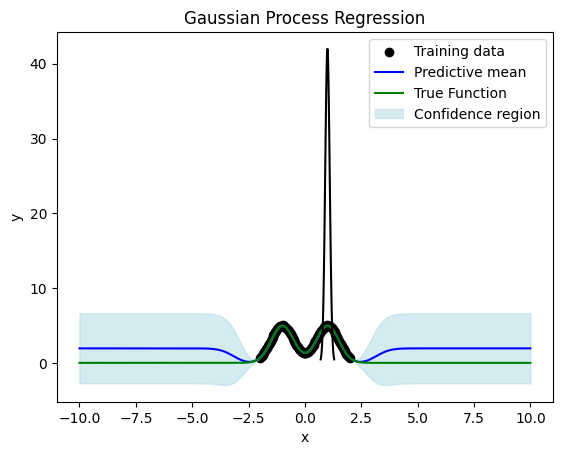

In [4]:
objective = lambda x: -x**2
#objective = lambda x: -20.0 * torch.exp(-0.2 * torch.sqrt(0.5 * x**2))-torch.exp(0.5 * (torch.cos(2*torch.pi*x))) + torch.exp(torch.tensor(1.)) + 20
objective = lambda x: -Ackley(1)(x) 
objective = lambda x: 5*torch.exp(-2*(x - 1)**2) + 5*torch.exp(-2*(x + 1)**2)

from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([1.]), torch.diag(torch.tensor([.1]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 100
bounds = 2
lb, up= -10., 10.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
#train_Y = (objective(train_X)).sum(dim=1, keepdim=True)
train_Y = objective(train_X).reshape(-1,1)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)

In [40]:
mean_distrib, var_distrib = torch.tensor([0.]), torch.diag(torch.tensor([1.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
quad = Quadrature(model=model,
            distribution=quad_distrib, 
            c2=0.01)
quad.quadrature()
quad.gradient_direction()
quad.d_epsilon

tensor([[-0.1550]], dtype=torch.float64, grad_fn=<UnsafeViewBackward0>)

In [41]:
t_linspace = torch.linspace(0., 10., 50, dtype=train_X.dtype)
result_wolfe = []
for t in t_linspace:
    result_wolfe.append(quad.compute_p_wolfe(t))
wolfe_tensor = torch.tensor(result_wolfe)

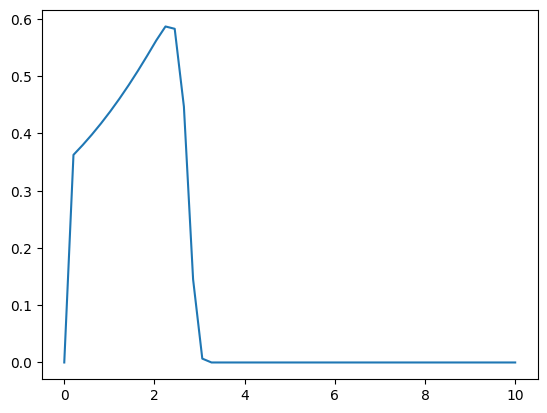

In [42]:
plt.plot(t_linspace, wolfe_tensor.detach().cpu())

In [44]:
nearestPD(torch.tensor([[-1.]]))

tensor([[1.1921e-07]])